# Comparison of the gradient algorithms with LASSO example

For solving the Lasso problem:

$$\min_{\beta \in \R^p}\frac{1}{2}||X\beta-Y||^2+\lambda||\beta||_1$$

we write our own codes to implement the methods:     
* coordinate descent (CD)
* proximal gradient (PG)
* accelerated proximal gradient (APG)
* accelerated proximal gradient with restart techniques (APG-restart) (with 100 steps per restart)

## Import libs

In [1]:
import numpy as np
import scipy
from time import time_ns
import matplotlib.pyplot as plt

## Construct values

Here, we set $n = 1000$, $p = 5000$.       
Generate an $n×p$ random matrix $X$ where each entry $X_{ij}$ is a random variable drawn from the standard normal distribution $N(0, 1)$, and then standardize each column of X — subtracting its mean and dividing by its standard
deviation.     
Generate a random sparse vector $\beta^* \in \R^p$ with approximately $0.05p$ nonzero entries by `scipy.sparse.random`.     
Let $Y = X\beta^*+0.01\epsilon$ where $\epsilon_i \sim N(0, 1), i \in [n]$ is the Gaussian noise.

In [2]:
np.random.seed(677)
n, p = 1000, 5000
X = np.random.rand(n, p)
X = (X-np.mean(X))/np.std(X)
beta_star = scipy.sparse.random(p, 1, 0.05)
epsilon = np.random.rand(n, 1)
Y = X@beta_star+0.01*epsilon
assert(np.abs(np.mean(X))<1e-6)
assert(np.abs(1-np.std(X))<1e-6)
assert(Y.shape==(1000,1))
assert(np.abs(sum(Y)-337.65543745)<1e-6)

In this case, we set:
* the penalty parameter be $\lambda = 0.1||X^TY||_\infty$;      
* always use the initial point $\beta^{(0)} = 0$;      
* $L=\lambda_{max}(X^TX)$ ($\lambda_{max}$ denotes the largest eigenvalue of a matrix);     
* step size $\alpha=1/L$ for PG and APG;    
* the tolerance for convergence = 1e-3
* the termination condition: achieves the accuracy of tolerance in the relative residual error for an approximate solution $\beta^{(k)}$, namely, $$r(\beta^{(k)}):=||\beta^{(k)}-S_\lambda{(\beta^{(k)}-X^T(X\beta^{(k)}-Y))}||_2\lt tolerance$$

## Gradient with toelrance=1e-3

In [3]:
class GradientAlgo:
    def __init__(self, X, Y, alpha_factor=1):
        self.X = X
        self.Y = Y
        self.eigen_values, _ = np.linalg.eig(np.dot(X.T, X))
        Lipschitz_constant = np.max(self.eigen_values)
        self.alpha_factor = alpha_factor
        self.alpha = alpha_factor/float(Lipschitz_constant)
        self.lamb = 0.1*np.max(np.dot(X.T, Y))

    def soft_threshold(self, thres, x):
        return np.sign(x)*(np.abs(x)>thres)*(np.abs(x)-thres)
    
    def CD(self, max_steps=3000, tolerance=1e-3):
        cd_betas = [np.zeros(p).reshape([p, 1])]
        cd_residual_errors = []
        cd_times = []
        cd_start_time = time_ns()
        for step in range(max_steps):
            beta_new = cd_betas[-1].copy()
            for i in range(p):
                X_i = X[:,i]
                norm_X_i = np.linalg.norm(X_i)
                inv_norm_X_i_sqaure = 1/(norm_X_i*norm_X_i)
                beta_i = beta_new[i]
                # X_i.T@(Y-X_{-i}@beta_[-i])/(X_i.T@X_i) = X_i.T(Y-(X@beta-X_{i}@beta_{i}))/(X_i.T@X_i) = X_i.T@((Y-X@beta)+X_{i}@beta_{i})/(X_i.T@X_i) = beta_i+X_i.T@(Y-X@beta)/(X_i.T@X_i)
                beta_new[i] = self.soft_threshold(self.lamb*inv_norm_X_i_sqaure, beta_i + np.dot(X_i.T, Y - X@beta_new)*inv_norm_X_i_sqaure)
            cd_betas.append(beta_new)
            diff = beta_new - self.soft_threshold(self.lamb, beta_new-np.dot(X.T, X@beta_new-Y))
            error = np.linalg.norm(diff)
            cd_residual_errors.append(error)
            cd_times.append(time_ns())
            # print(f"Error at step {step}: {error}")
            if error < tolerance:
                print(f"Error {error} < {tolerance}, exit at step {step}...")
                break
        print(f"Total time cost: {(cd_times[-1]-cd_start_time)/1e9}")
        self.cd_betas = cd_betas
        self.cd_residual_errors = cd_residual_errors
        self.cd_times = cd_times
        self.cd_start_time = cd_start_time
    
    def PG(self, max_steps=3000, tolerance=1e-3):
        pg_betas = [np.zeros(p).reshape([p, 1])]
        pg_residual_errors = []
        pg_times = []
        pg_start_time = time_ns()
        for step in range(max_steps):
            beta_bar = pg_betas[-1]
            beta_new = self.soft_threshold(self.lamb*self.alpha, beta_bar-self.alpha*np.dot(X.T, X@beta_bar-Y))
            pg_betas.append(beta_new)
            diff = beta_new - self.soft_threshold(self.lamb, beta_new-np.dot(X.T, X@beta_new-Y))
            error = np.linalg.norm(diff)
            pg_residual_errors.append(error)
            pg_times.append(time_ns())
            # print(f"Error at step {step}: {error}")
            if error < tolerance:
                print(f"Error {error} < {tolerance}, exit at step {step}...")
                break
        print(f"Total time cost: {(pg_times[-1]-pg_start_time)/1e9}")
        self.pg_betas = pg_betas
        self.pg_residual_errors = pg_residual_errors
        self.pg_times = pg_times
        self.pg_start_time = pg_start_time
    
    def APG(self, max_steps=3000, tolerance=1e-3):
        t_cur, t_next = 1, 1
        apg_betas = [np.zeros(p).reshape([p, 1]), np.zeros(p).reshape([p, 1])] # first 0 is auxiliary
        apg_residual_errors = []
        apg_times = []
        apg_start_time = time_ns()
        for step in range(max_steps):
            beta_bar = apg_betas[-1]+(t_cur-1)/t_next*(apg_betas[-1]-apg_betas[-2])
            beta_new = self.soft_threshold(self.lamb*self.alpha, beta_bar-self.alpha*np.dot(X.T, X@beta_bar-Y))
            apg_betas.append(beta_new)
            t_cur = (1+np.sqrt(1+4*t_next*t_next))/2
            t_cur, t_next = t_next, t_cur
            diff = beta_new - self.soft_threshold(self.lamb, beta_new-np.dot(X.T, X@beta_new-Y))
            error = np.linalg.norm(diff)
            apg_residual_errors.append(error)
            apg_times.append(time_ns())
            if error < tolerance:
                print(f"Error {error} < {tolerance}, exit at step {step}...")
                break
        print(f"Total time cost: {(apg_times[-1]-apg_start_time)/1e9}")
        self.apg_betas = apg_betas
        self.apg_residual_errors = apg_residual_errors
        self.apg_times = apg_times
        self.apg_start_time = apg_start_time
    
    def APG_restart(self, max_steps=3000, tolerance=1e-3, steps_per_epoch=100):
        t_cur, t_next = 1, 1
        apg_restart_betas = [np.zeros(p).reshape([p, 1])]
        apg_restart_residual_errors = []
        apg_restart_times = []
        apg_restart_start_time = time_ns()
        for epoch in range(max_steps//steps_per_epoch):
            t_cur, t_next = 1, 1
            apg_restart_betas.append(apg_restart_betas[-1])
            for step in range(steps_per_epoch):
                beta_bar = apg_restart_betas[-1]+(t_cur-1)/t_next*(apg_restart_betas[-1]-apg_restart_betas[-2])
                beta_new = self.soft_threshold(self.lamb*self.alpha, beta_bar-self.alpha*np.dot(X.T, X@beta_bar-Y))
                apg_restart_betas.append(beta_new)
                t_cur = (1+np.sqrt(1+4*t_next*t_next))/2
                t_cur, t_next = t_next, t_cur
                diff = beta_new - self.soft_threshold(self.lamb, beta_new-np.dot(X.T, X@beta_new-Y))
                error = np.linalg.norm(diff)
                apg_restart_residual_errors.append(error)
                apg_restart_times.append(time_ns())
                if error < tolerance:
                    print(f"Error {error} < {tolerance}, exit at step {steps_per_epoch*epoch+step}...")
                    break
            if apg_restart_residual_errors[-1] < tolerance:
                break
        print(f"Total time cost: {(apg_restart_times[-1]-apg_restart_start_time)/1e9}")
        self.apg_restart_betas = apg_restart_betas
        self.apg_restart_residual_errors = apg_restart_residual_errors
        self.apg_restart_times = apg_restart_times
        self.apg_restart_start_time = apg_restart_start_time

    def plot(self, residual_errors, times, start_time, title):
        _, _ = plt.subplots(2, 2, figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(np.log10(residual_errors))
        plt.xlabel('iterations')
        plt.ylabel('log10(r(beta^k))')
        plt.title('Log residual error vs iteration')

        plt.subplot(1, 2, 2)
        plt.plot(np.log10(np.array(times)-start_time))
        plt.xlabel('iterations')
        plt.ylabel('log10(time)')
        plt.title('Log time taken vs iteration')

        plt.suptitle(title)
        plt.show()
    
    def plot_all(self):
        _, _ = plt.subplots(2, 2, figsize=(15, 5))

        plt.subplot(1, 2, 1)
        if hasattr(self, 'cd_residual_errors'):
            plt.plot(np.log10(self.cd_residual_errors), label="CD")
        if hasattr(self, 'pg_residual_errors'):
            plt.plot(np.log10(self.pg_residual_errors), label="PG")
        if hasattr(self, 'apg_residual_errors'):
            plt.plot(np.log10(self.apg_residual_errors), label="APG")
        if hasattr(self, 'apg_restart_residual_errors'):
            plt.plot(np.log10(self.apg_restart_residual_errors), label="APG restart")
        plt.xlabel('iterations')
        plt.ylabel('log10(r(beta^k))')
        plt.legend()
        plt.title('Log residual error vs iteration')

        plt.subplot(1, 2, 2)
        if hasattr(self, 'cd_times'):
            plt.plot(np.log10(np.array(self.cd_times)-self.cd_start_time), label="CD")
        if hasattr(self, 'pg_times'):
            plt.plot(np.log10(np.array(self.pg_times)-self.pg_start_time), label="PG")
        if hasattr(self, 'apg_times'):
            plt.plot(np.log10(np.array(self.apg_times)-self.apg_start_time), label="APG")
        if hasattr(self, 'apg_restart_times'):
            plt.plot(np.log10(np.array(self.apg_restart_times)-self.apg_restart_start_time), label="APG restart")
        plt.xlabel('iterations')
        plt.ylabel('log10(time)')
        plt.legend()
        plt.title('Log time taken vs iteration')

        plt.suptitle("Overall comparison")
        plt.show()

In [4]:
gradient_algo = GradientAlgo(X, Y)

/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  self.alpha = alpha_factor/float(Lipschitz_constant)


### Coordinate Descent (CD)

Algorithm for LASSO:
* Initialize $\beta$
* **repeat** until convergence
  * for i = 1, ..., p
    * $\beta_i \leftarrow \frac{X_{i}(Y-X_{-i}\beta_{-i})}{||X_i||^2}$
  * **end(for)**
* **end(repeat)**

In [5]:
gradient_algo.CD()

Error 0.0009473628830129358 < 0.001, exit at step 45...
Total time cost: 264.476946


/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:124: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:130: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


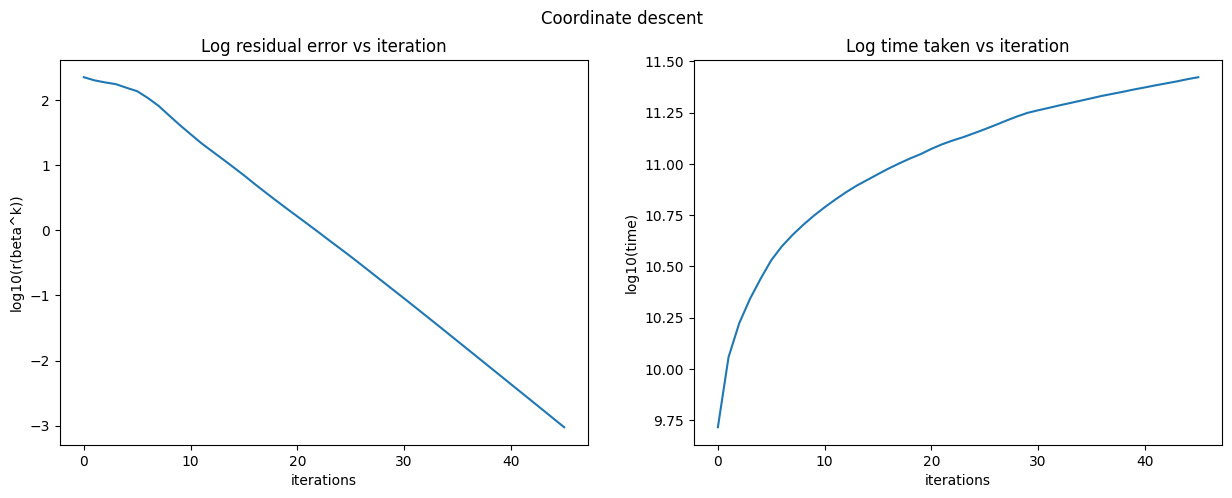

In [6]:
gradient_algo.plot(gradient_algo.cd_residual_errors, gradient_algo.cd_times, gradient_algo.cd_start_time, "Coordinate descent")

### PG

Algorithm:
* Choose $\beta^{(0)}$, constant step length $\alpha \gt 0$. Set $k \leftarrow 0$
* **repeat** until convergence
  * $\beta^{k+1} = P_{\alpha g}(\beta^{(k)} - \alpha \nabla f(\beta^{(k)}))$
  * $k \leftarrow k+1$
* **end(repeat)**
* **return** $\beta^{(k)}$


In [7]:
gradient_algo.PG()

Error 0.0009926063928833043 < 0.001, exit at step 975...
Total time cost: 4.769711


/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:124: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:130: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


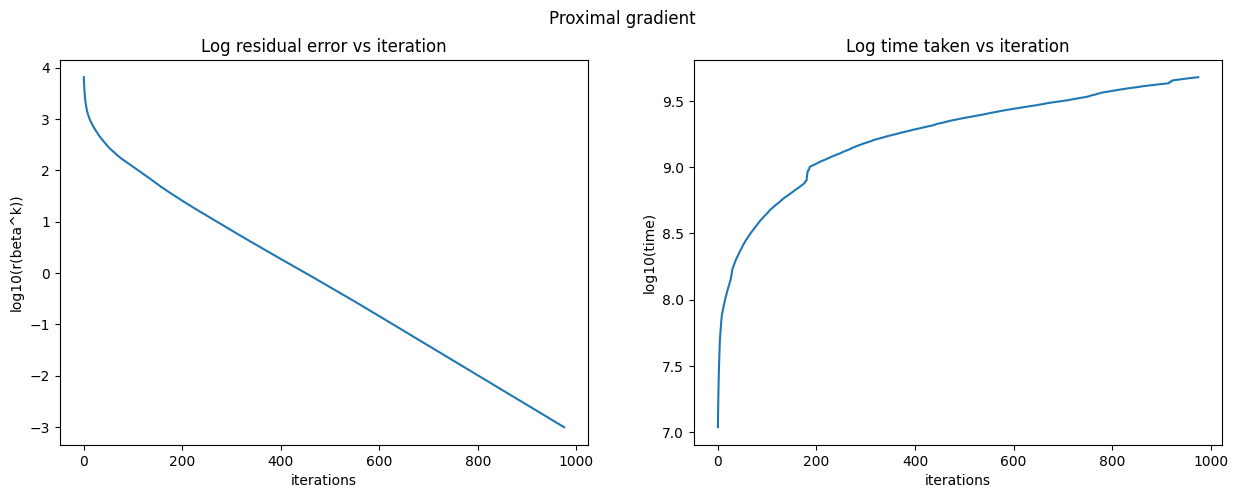

In [8]:
gradient_algo.plot(gradient_algo.pg_residual_errors, gradient_algo.pg_times, gradient_algo.pg_start_time, "Proximal gradient")

### APG

Algorithm:
* Choose $\beta^{(0)}$, constant step length $\alpha \gt 0$. Set $t_0 = t_1 = 1, k \leftarrow 0$
* **repeat** until convergence
  * $\bar{\beta_{(0)}} = \beta^{(k)} + \frac{t_k-1}{t_{k+1}}(\beta^{(k)} - \beta^{(k-1)})$
  * $\beta^{k+1} = P_{\alpha g}(\bar{\beta^{(k)}} - \alpha \nabla f(\bar{\beta^{(k)}}))$
  * $k \leftarrow k+1$
  * $t_{k+1} = \frac{1+\sqrt{1+4t_k^2}}{2}$
* **end(repeat)**
* **return** $\beta^{(k)}$

For LAASO and $alpha = 1/L$:
$$P_{\alpha g}(\bar{\beta^{(k)}} - \alpha \nabla f(\bar{\beta^{(k)}}))$$
$$= S_{\lambda/L}(\bar{\beta^{(k)}}-\frac{1}{L}{X^T(X\bar{\beta^{(k)}}-Y)})$$
where $$S$$ is the ***soft thresholding operator*** $S: \R^n \rightarrow \R^n$:
$$S_\lambda(x) = \begin{bmatrix} sign(x_1)\max{\{|x_1|-\lambda, 0\}} \\ sign(x_2)\max{\{|x_2|-\lambda, 0\}} \\ \vdots \\ sign(x_n)\max{\{|x_n|-\lambda, 0\}} \end{bmatrix}$$

In [9]:
gradient_algo.APG()

Error 0.0009542971348123911 < 0.001, exit at step 718...
Total time cost: 3.408527


/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:124: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:130: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


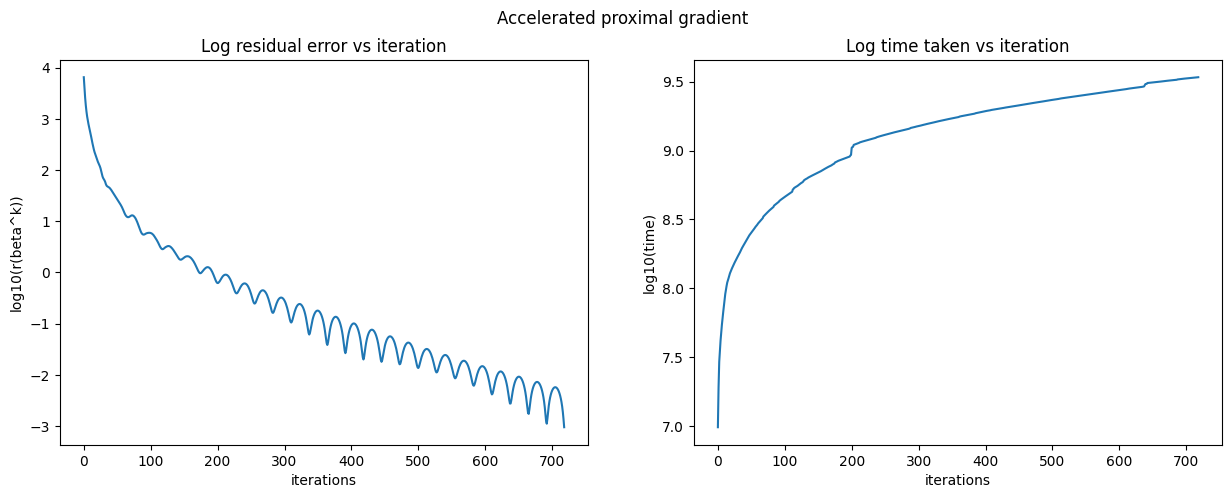

In [10]:
gradient_algo.plot(gradient_algo.apg_residual_errors, gradient_algo.apg_times, gradient_algo.apg_start_time, "Accelerated proximal gradient")

## APG with restart

In [11]:
steps_per_epoch = 100
gradient_algo.APG_restart(steps_per_epoch = steps_per_epoch)

Error 0.0009212539936994424 < 0.001, exit at step 284...
Total time cost: 1.341399


/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:124: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:130: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


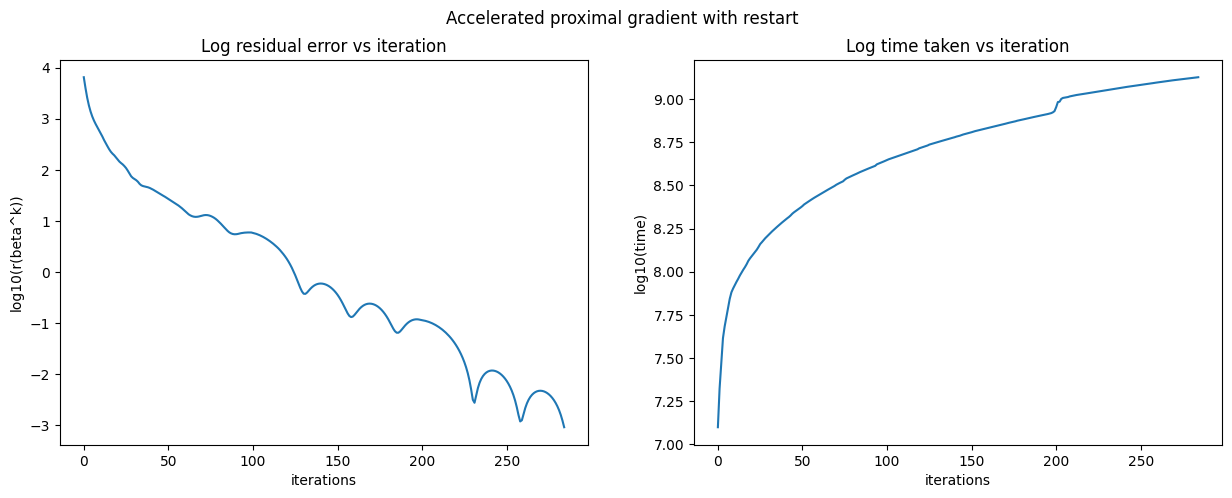

In [12]:
gradient_algo.plot(gradient_algo.apg_restart_residual_errors, gradient_algo.apg_restart_times, gradient_algo.apg_restart_start_time, "Accelerated proximal gradient with restart")

In [13]:
# The residual errors in the first epoch of APG restart should be the same as that of APG
assert(all(np.array(gradient_algo.apg_residual_errors[:steps_per_epoch]) - np.array(gradient_algo.apg_restart_residual_errors[:steps_per_epoch]) == 0))

### Plot all in one

/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:142: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:156: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


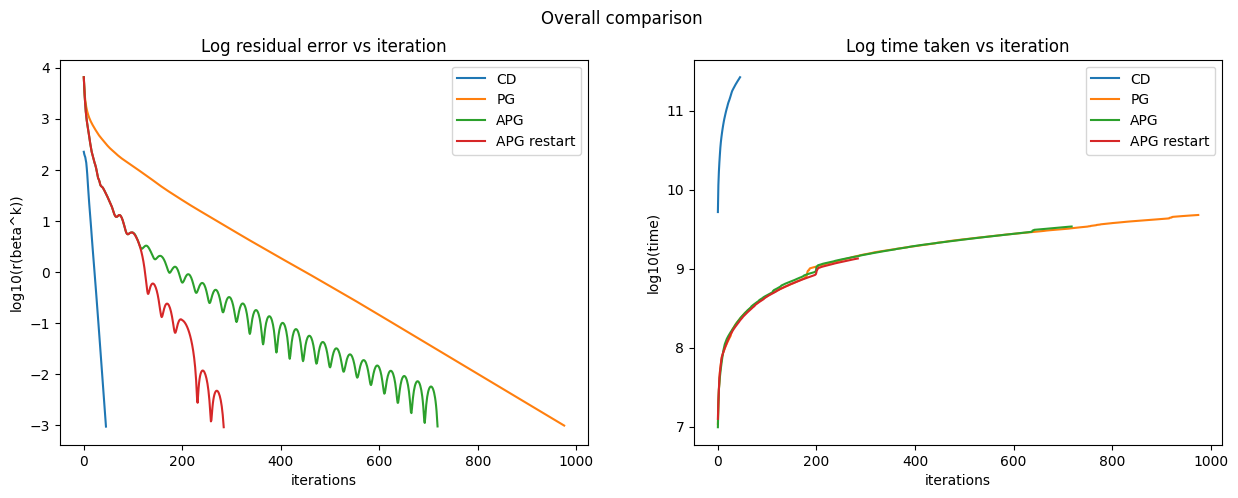

In [14]:
gradient_algo.plot_all()

Result table:

||Iterations|Time cost|
|:--:|:--:|:--:|
|CD|45|264.476946|
|PG|975|4.769711|
|APG|718|3.408527|
|APG-restart|284|1.341399|

Clearly as the result shows:
* The Coordinate Descent uses the least iterations to achieve the convergence, while it uses the most time among all.
* The Proximal Gradient behaves like a linear under the log value compared to the iteration.
* The APG-restart outperforms pure APG method, only using half of its iterations to achieve the convergence.
* The PG, APG, and APG-restart's time curves almost overlap with each other because of the similarity of the algorithm used.

## Test whether APG and APG restart can reach 1e-10 within 3k iterations

In [15]:
gradient_algo2 = GradientAlgo(X, Y)

/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  self.alpha = alpha_factor/float(Lipschitz_constant)


In [16]:
gradient_algo2.APG(max_steps=3000, tolerance=1e-10)
gradient_algo2.APG_restart(max_steps=3000, tolerance=1e-10, steps_per_epoch=100)

Error 9.72929251032882e-11 < 1e-10, exit at step 2686...
Total time cost: 12.446968
Error 6.97094134988406e-11 < 1e-10, exit at step 631...
Total time cost: 3.701162


/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:142: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:156: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


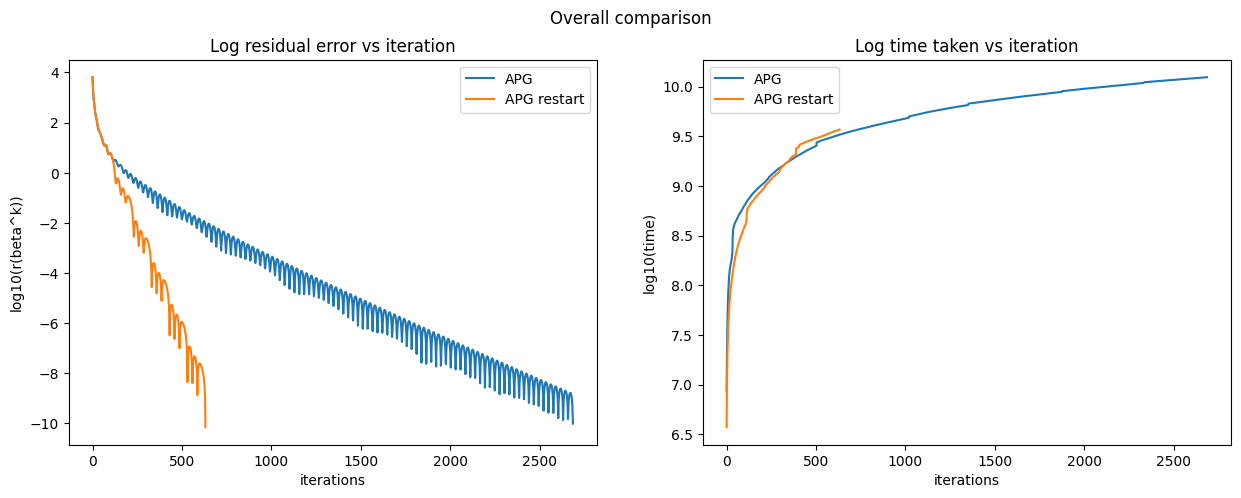

In [17]:
gradient_algo2.plot_all()

## Compare different Alpha under tolerance 1e-6 using APG and APG-restart

In [18]:
gradient_algo3 = GradientAlgo(X, Y, alpha_factor=1)

/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  self.alpha = alpha_factor/float(Lipschitz_constant)


In [19]:
gradient_algo3.APG(max_steps = 3000, tolerance = 1e-6)
gradient_algo3.APG_restart(max_steps = 3000, tolerance = 1e-6, steps_per_epoch = 100)

Error 7.789675688031546e-07 < 1e-06, exit at step 1484...
Total time cost: 9.213253
Error 3.2028707856435117e-07 < 1e-06, exit at step 431...
Total time cost: 3.188795


In [20]:
gradient_algo4 = GradientAlgo(X, Y, alpha_factor=1.5)

/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  self.alpha = alpha_factor/float(Lipschitz_constant)


In [21]:
gradient_algo4.APG(max_steps = 3000, tolerance = 1e-6)
gradient_algo4.APG_restart(max_steps = 3000, tolerance = 1e-6, steps_per_epoch = 100)

Error 9.212407772191865e-07 < 1e-06, exit at step 1054...
Total time cost: 7.723349
Error 9.570395858102385e-07 < 1e-06, exit at step 390...
Total time cost: 2.611628


/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/2583434673.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/2583434673.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


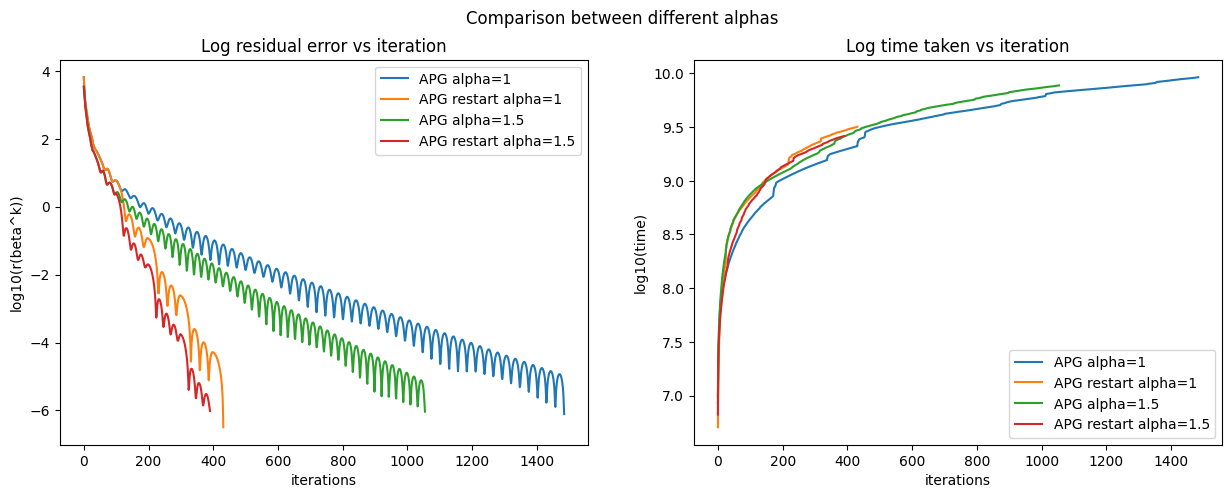

In [22]:
_, _ = plt.subplots(2, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(np.log10(gradient_algo3.apg_residual_errors), label="APG alpha=1")
plt.plot(np.log10(gradient_algo3.apg_restart_residual_errors), label="APG restart alpha=1")
plt.plot(np.log10(gradient_algo4.apg_residual_errors), label="APG alpha=1.5")
plt.plot(np.log10(gradient_algo4.apg_restart_residual_errors), label="APG restart alpha=1.5")
plt.xlabel('iterations')
plt.ylabel('log10(r(beta^k))')
plt.legend()
plt.title('Log residual error vs iteration')

plt.subplot(1, 2, 2)
plt.plot(np.log10(np.array(gradient_algo3.apg_times)-gradient_algo3.apg_start_time), label="APG alpha=1")
plt.plot(np.log10(np.array(gradient_algo3.apg_restart_times)-gradient_algo3.apg_restart_start_time), label="APG restart alpha=1")
plt.plot(np.log10(np.array(gradient_algo4.apg_times)-gradient_algo4.apg_start_time), label="APG alpha=1.5")
plt.plot(np.log10(np.array(gradient_algo4.apg_restart_times)-gradient_algo4.apg_restart_start_time), label="APG restart alpha=1.5")
plt.xlabel('iterations')
plt.ylabel('log10(time)')
plt.legend()
plt.title('Log time taken vs iteration')

plt.suptitle("Comparison between different alphas")
plt.show()

In [23]:
gradient_algo5 = GradientAlgo(X, Y, alpha_factor=2)
gradient_algo5.APG(max_steps = 3000, tolerance = 1e-6)
gradient_algo5.APG_restart(max_steps = 3000, tolerance = 1e-6, steps_per_epoch = 100)

/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  self.alpha = alpha_factor/float(Lipschitz_constant)


Error 9.852638860973071e-07 < 1e-06, exit at step 795...
Total time cost: 4.954714
Error 8.47826315712029e-07 < 1e-06, exit at step 318...
Total time cost: 1.580151


In [24]:
gradient_algo6 = GradientAlgo(X, Y, alpha_factor=5)
gradient_algo6.APG(max_steps = 3000, tolerance = 1e-6)
gradient_algo6.APG_restart(max_steps = 3000, tolerance = 1e-6, steps_per_epoch = 100)

/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  self.alpha = alpha_factor/float(Lipschitz_constant)
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:78: RuntimeWarning: invalid value encountered in matmul
  diff = beta_new - self.soft_threshold(self.lamb, beta_new-np.dot(X.T, X@beta_new-Y))
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:74: RuntimeWarning: invalid value encountered in matmul
  beta_new = self.soft_threshold(self.lamb*self.alpha, beta_bar-self.alpha*np.dot(X.T, X@beta_bar-Y))


Total time cost: 15.727711


/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:106: RuntimeWarning: invalid value encountered in matmul
  diff = beta_new - self.soft_threshold(self.lamb, beta_new-np.dot(X.T, X@beta_new-Y))
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3521293269.py:102: RuntimeWarning: invalid value encountered in matmul
  beta_new = self.soft_threshold(self.lamb*self.alpha, beta_bar-self.alpha*np.dot(X.T, X@beta_bar-Y))


Total time cost: 14.796105


/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3426821579.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)
/var/folders/lw/80dbxz_j6kq02vhswvq422kr0000gn/T/ipykernel_27371/3426821579.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


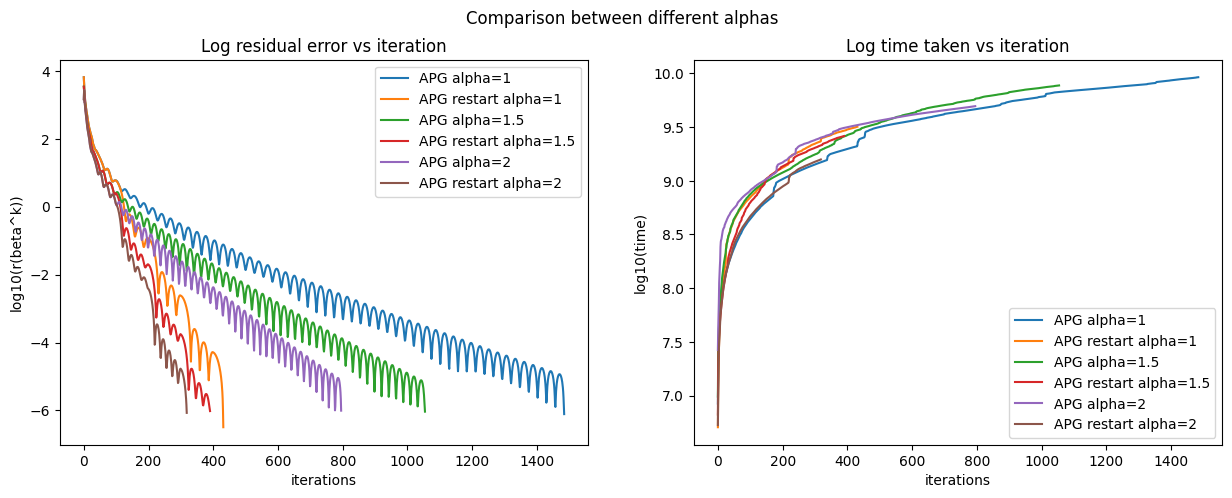

In [28]:
_, _ = plt.subplots(2, 2, figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(np.log10(gradient_algo3.apg_residual_errors), label="APG alpha=1")
plt.plot(np.log10(gradient_algo3.apg_restart_residual_errors), label="APG restart alpha=1")
plt.plot(np.log10(gradient_algo4.apg_residual_errors), label="APG alpha=1.5")
plt.plot(np.log10(gradient_algo4.apg_restart_residual_errors), label="APG restart alpha=1.5")
plt.plot(np.log10(gradient_algo5.apg_residual_errors), label="APG alpha=2")
plt.plot(np.log10(gradient_algo5.apg_restart_residual_errors), label="APG restart alpha=2")
plt.xlabel('iterations')
plt.ylabel('log10(r(beta^k))')
plt.legend()
plt.title('Log residual error vs iteration')

plt.subplot(1, 2, 2)
plt.plot(np.log10(np.array(gradient_algo3.apg_times)-gradient_algo3.apg_start_time), label="APG alpha=1")
plt.plot(np.log10(np.array(gradient_algo3.apg_restart_times)-gradient_algo3.apg_restart_start_time), label="APG restart alpha=1")
plt.plot(np.log10(np.array(gradient_algo4.apg_times)-gradient_algo4.apg_start_time), label="APG alpha=1.5")
plt.plot(np.log10(np.array(gradient_algo4.apg_restart_times)-gradient_algo4.apg_restart_start_time), label="APG restart alpha=1.5")
plt.plot(np.log10(np.array(gradient_algo5.apg_times)-gradient_algo5.apg_start_time), label="APG alpha=2")
plt.plot(np.log10(np.array(gradient_algo5.apg_restart_times)-gradient_algo5.apg_restart_start_time), label="APG restart alpha=2")
plt.xlabel('iterations')
plt.ylabel('log10(time)')
plt.legend()
plt.title('Log time taken vs iteration')

plt.suptitle("Comparison between different alphas")
plt.show()

Result table:

|Iteration|Alpha=1|Alpha=1.5|Alpha=2|
|:--:|:--:|:--:|:--:|
|APG|1484|1054|795|
|APG-restart|431|390|318|

|Time|Alpha=1|Alpha=1.5|Alpha=2|
|:--:|:--:|:--:|:--:|
|APG|9.213253|7.723349|4.954714|
|APG-restart|3.188795|2.611628|1.580151|

As the result shows:
* Normally speaking, the higher the alpha, the faster it can converge.
* However, the alpha can not be too high to make the value NaN.